we are directly using insights from EDA

In [2]:
%pip install imbalanced-learn

   ---------------------------------------- 0.0/235.4 kB ? eta -:--:--
   -------------------------------------- - 225.3/235.4 kB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 235.4/235.4 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [5]:
df = pd.read_csv("fake_job_postings.csv")

In [6]:
df.sample(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
7385,7386,Customer Success Intern,"DE, BE, Berlin",Customer Success,NaN,NaN,We're looking for a student or recent graduate...,"You are a digital native, with a technical und...",The Web is changing and becoming more interact...,0,1,1,Other,NaN,Bachelor's Degree,Computer Software,Customer Service,0
9216,9217,Front End Developer,"US, FL, Deerfield Beach",Marketing,NaN,NaN,We are a nationally recognized startup company...,RequirementsMust be an expert level in Adobe C...,NaN,0,0,1,Full-time,Mid-Senior level,Associate Degree,Marketing and Advertising,Marketing,0
16134,16135,Community Manager,"BR, RJ, Rio de Janeiro",NaN,NaN,VTEX is the leading e-commerce solution provid...,Impeccable writing and grammar skills in Portu...,NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3314,3315,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
6496,6497,English Product Manager,"GR, , Athens",Editorial,NaN,Daily Secret is one of the fastest growing dig...,We are looking for a talented and driven Engli...,is a native English speaker (American English ...,"first-hand experience at a fast-growing, globa...",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Writing/Editing,0


Doing Data preprocessing based on EDA

In [7]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [8]:
df['location'].fillna('Unknown', inplace=True)
df['department'].fillna('Unknown', inplace=True)
df['salary_range'].fillna('Not Specified', inplace=True)
df['employment_type'].fillna('Not Specified', inplace=True)
df['required_experience'].fillna('Not Specified', inplace=True)
df['required_education'].fillna('Not Specified', inplace=True)
df['industry'].fillna('Not Specified', inplace=True)
df['function'].fillna('Not Specified', inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29168\1166088697.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location'].fillna('Unknown', inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29168\1166088697.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [9]:
df['combined_text'] = df[['title', 'location', 'salary_range', 'company_profile', 'description', 
                          'requirements', 'benefits', 'employment_type', 
                          'required_experience', 'required_education', 'industry', 
                          'function', 'department']].apply(
    lambda x: ' '.join(x.fillna('').astype(str)), axis=1
)

In [10]:
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('Missing')

Droping individual columns that won't be available in real world all the time

In [11]:
df.drop(columns=['title',
                 'location',
                 'salary_range',
                 'company_profile',
                 'description',
                 'requirements',
                 'benefits',
                 'employment_type',
                 'required_experience',
                 'required_education',
                 'industry',
                 'function',
                 'department',
                 'job_id',
                 'has_questions',
                 'telecommuting'], inplace=True)

In [12]:
df.head()

,has_company_logo,fraudulent,combined_text
0,1,0,"Marketing Intern US, NY, New York Not Specifie..."
1,1,0,"Customer Service - Cloud Video Production NZ, ..."
2,1,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,1,0,"Account Executive - Washington DC US, DC, Wash..."
4,1,0,"Bill Review Manager US, FL, Fort Worth Not Spe..."


In [13]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower().strip()  
    return text

In [14]:
df['combined_text'] = df['combined_text'].apply(clean_text)

In [15]:
le = LabelEncoder()
df['fraudulent'] = le.fit_transform(df['fraudulent'])

In [16]:
df.head()

,has_company_logo,fraudulent,combined_text
0,1,0,marketing intern us ny new york not specified ...
1,1,0,customer service cloud video production nz a...
2,1,0,commissioning machinery assistant cma us ia we...
3,1,0,account executive washington dc us dc washing...
4,1,0,bill review manager us fl fort worth not speci...


In [17]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['combined_text'])
sequences = tokenizer.texts_to_sequences(df['combined_text'])

In [18]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y = df['fraudulent']

We are using SMOTE to handle class imbalance and then resampling the data.

In [19]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [20]:
print("Original Dataset Shape:", X.shape, y.shape)
print("After SMOTE Resampling Shape:", X_resampled.shape, y_resampled.shape)

Original Dataset Shape: (17880, 200) (17880,)
After SMOTE Resampling Shape: (34028, 200) (34028,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [26]:
lstm_model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 217s 245ms/step - accuracy: 0.9482 - loss: 0.1558 - val_accuracy: 0.9790 - val_loss: 0.0671
Epoch 2/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 214s 251ms/step - accuracy: 0.9785 - loss: 0.0735 - val_accuracy: 0.9790 - val_loss: 0.0654
Epoch 3/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 215s 253ms/step - accuracy: 0.9832 - loss: 0.0563 - val_accuracy: 0.9819 - val_loss: 0.0632
Epoch 4/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 222s 261ms/step - accuracy: 0.9870 - loss: 0.0445 - val_accuracy: 0.9647 - val_loss: 0.1635
Epoch 5/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 205s 241ms/step - accuracy: 0.9897 - loss: 0.0355 - val_accuracy: 0.9822 - val_loss: 0.0629


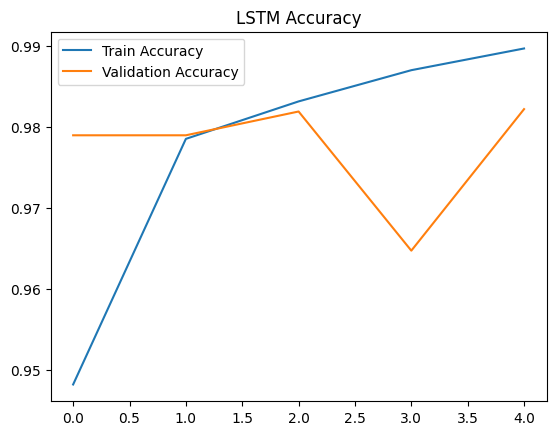

In [28]:
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.legend()
plt.show()

In [29]:
print("LSTM Model Evaluation")
lstm_predictions = (lstm_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, lstm_predictions))
print("LSTM F1 Score:", f1_score(y_test, lstm_predictions))

LSTM Model Evaluation
213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3396
           1       0.99      0.97      0.98      3410

    accuracy                           0.98      6806
   macro avg       0.98      0.98      0.98      6806
weighted avg       0.98      0.98      0.98      6806

LSTM F1 Score: 0.9820873427091044


Saving the LSTM Model

In [31]:
lstm_model.save("Fake_job_detection.h5")

Saving the Tokenizer

In [33]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)